Import the libraries to be used throughout

In [10]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.image as mpimg
from scipy import misc
from skimage import io

First, we read all the images needed for exercises 1-3. Note that the retinal image mask has values 0 and 255; we turn them into 0 and 1.

In [122]:
# reading the images in as numpy arrays
Iret = io.imread('data/01_retinal.png')
Imask = io.imread('data/01_test_mask.png')
Imask = Imask/255
Imask = Imask.astype(int)
Iman1 = io.imread('data/01_manual1.png')
Iman2 = io.imread('data/01_manual2.png')
smartgirl = io.imread('data/smartgirl.jpg')

**Exercise 1** Write the threshold_image function and apply it to find a decent threshold

In [123]:
# Input: 1) I: A grayscale image loaded as a n x m numpy array using e.g. I = io.imread('myfile.xxx'), 
#           where io is loaded from skimage
#        2) t: The threshold at which to threshold the image
#
# Output: 3) The thresholded image I_th as a n x m numpy array taking values 1 (retinal vessel) and 0 (background).

def threshold_image(I,t):
    I_th = np.less_equal(I, t)
    I_th = I_th.astype(int)
    
    return I_th

Apply the thresholding function and view and save the result...

/home/aasa/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "
/home/aasa/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: 180threshold.png is a low contrast image
  warn('%s is a low contrast image' % fname)


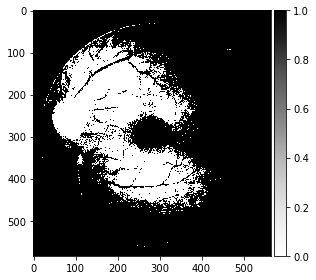

In [124]:
Ith = threshold_image(Iret, 180)

io.imshow(Ith, cmap=cm.Greys)
io.imsave('180threshold.png', Ith)

**Exercise 2** Segmentation evaluation

In [125]:
# input: 1) seg: Your own segmentation, loaded as a (n x m) numpy array taking integer values 1 (vessel) and 0 (background)
#        2) gt: The ground truth segmentation, loaded as a (n x m) numpy array taking integer values 1 (vessel) and 0 (background)
#        3) mask: The retinal image mask, filtering away what is outside the image, loaded as a (n x m) numpy array taking integer values 1 (inside image) and 0 (outside image)
# 
# output: A tuple consisting of the following 7 numbers (in that order):
#         1) TP
#         2) FP
#         3) TN
#         4) FN
#         5) Accuracy
#         6) Sensitivity
#         7) Specificity

def seg_eval(seg,gt,mask):
    seg = np.multiply(seg, mask)        # leave out mask
    gt = np.multiply(gt, mask)          # leave out mask
    diff = np.abs(seg-gt)    
    neg_gt = 1-gt
    neg_gt = np.multiply(neg_gt,mask)   # leave out mask

    TP_array = gt*(1-diff)
    TP = TP_array.sum()
    FP_array = neg_gt*diff
    FP = FP_array.sum()
    TN_array = neg_gt*(1-diff)
    TN = TN_array.sum()
    FN_array = gt*diff
    FN = FN_array.sum()
    
    Acc = (TP + TN)/(TP+TN+FP+FN)
    Sens = TP/(TP+FN)
    Spec = TN/(TN+FP)
    
    return TP, FP, TN, FN, Acc, Sens, Spec

Next, apply the function to evaluate your segmentation or the second manual segmentation with respect to the ''ground truth'' first manual segmentation

In [127]:
segres = seg_eval(Ith, Iman1, Imask)
print(segres)
# Can also compute performance of one manual vs the other
segres21 = seg_eval(Iman2, Iman1, Imask)
# Print the results
print(segres21)

(21938, 130755, 64210, 7474, 0.38394309577184826, 0.74588603291173672, 0.32934116379863054)
(23428, 5417, 189548, 5984, 0.94918819665117193, 0.79654562763497894, 0.97221552586361659)


** Exercise 3:** Edge enhangement

3a) Implement finite differences

In [128]:
# Compute the centered finite difference partial derivatives of a 2D image
# 1) input: I: an image represented as a N x M numpy array
#           h: A step size determining the level of approximation
# 2) output: I_x: The centered finite difference partial derivative with respect to x as an N x M numpy array
#            I_y: The centered finite difference partial derivative with respect to y as an N x M numpy array
#
# OBS! Remember to handle the boundaries by padding the original image with zero
def findiff(I, h):
    N, M = I.shape
    zero_x = np.zeros((N,1)) # column of zeros to pad onto I for computing partial wrt x
    zero_y = np.zeros((1,M)) # column of zeros to pad onto I for computing partial wrt y
    padded_I_x = I # padded for partial wrt x
    padded_I_y = I # padded for partial wrt y
    for i in range(h):
        padded_I_x = np.concatenate((zero_x, padded_I_x, zero_x), axis = 1)
        padded_I_y = np.concatenate((zero_y, padded_I_y, zero_y), axis = 0)
        
    I_x = (padded_I_x[:,np.arange(2*h,M+2*h)] - padded_I_x[:,np.arange(0,M)])/(2*h)
    I_y = (padded_I_y[np.arange(2*h,N+2*h),:] - padded_I_y[np.arange(0,N),:])/(2*h)
    
    return I_x, I_y

3b) Next, compute the finite difference derivatives of the two images and visualize the output

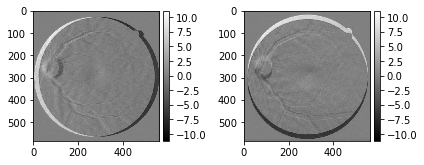

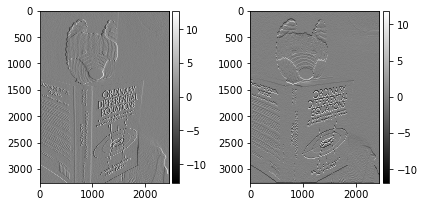

In [129]:
Iret_x, Iret_y = findiff(Iret, 10)
Ismart_x, Ismart_y = findiff(smartgirl, 10)
plt.figure()
io.imshow_collection([Iret_x, Iret_y],cmap='gray')
plt.figure()
io.imshow_collection([Ismart_x, Ismart_y],cmap='gray')

d) Implement gradient magnitude and apply it

In [130]:
# Compute the finite difference gradient magnitude of a 2D image.
# Hint: Use your implemented findiff.py from the previous exercise. You can import it by writing 
#       from findiff import findiff
# 1) input: I: an image represented as a N x M numpy array
#           h: A step size determining the level of approximation
# 2) output: I_g: The centered finite difference gradien magnitude as an N x M numpy array          
#
# OBS! Remember to handle the boundaries by padding the original image with zero
def gradmagn(I, h):
    #from findiff import findiff # needed outside Jupyter
    I_x, I_y = findiff(I, h)
    grad_I = np.sqrt(np.square(I_x) + np.square(I_y))
    
    return grad_I

Apply the gradient magnitude to the two images

/home/aasa/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


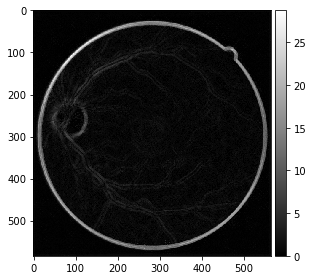

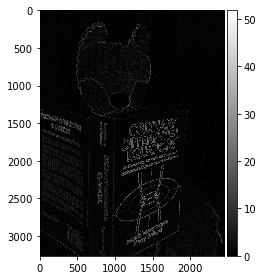

In [131]:
grad_ret = gradmagn(Iret, 5)
grad_smart = gradmagn(smartgirl, 3)
plt.figure()
io.imshow(grad_ret,cmap='gray')
plt.figure()
io.imshow(grad_smart,cmap='gray')

**Exercise 4:** Hand alignment. 

In [132]:
# First, load the data
data = np.loadtxt('data/hands.txt')
data.shape

(112, 40)

We will need the following function for plotting single hands:

In [133]:
# Plotting a single hand
def plot_hand(handvector):
    handx = handvector[0:55]
    handy = handvector[56:111]
    plt.plot(handx,handy)

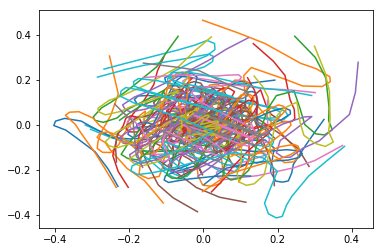

In [134]:
# Plotting all the hand data
D, N = data.shape
for n in np.arange(N):
    plot_hand(data[:,n])

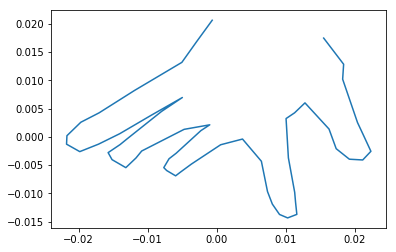

In [135]:
# Plotting the mean hand
meanhand = np.mean(data, 1)
plot_hand(meanhand)

4a) Implementing transformation of hands

In [136]:
# input:  a numpy array containing a vector with 112 coordinates corresponding to a hand in the form (x1 x2 ... x56 y1 y2 ... y56)
#         a double lambd representing the scaling parameter (note that we cannot call it lambda; this name is taken in python)
#         a double theta representing the rotation parameter
# output: a numpy array containing a vector with 112 coordinates corresponding to a hand in the form (x1 x2 ... x56 y1 y2 ... y56)

def transform_hand(handvector, lambd, theta):
    rotM = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    handx = handvector[0:56]
    handy = handvector[56:112]
    hand = np.array([handx,handy])
    transformed = np.matmul(rotM, lambd*hand)
    return transformed.flatten()

Applying the transformation to the first hand in the dataset with scaling 2 and rotation 30 degrees

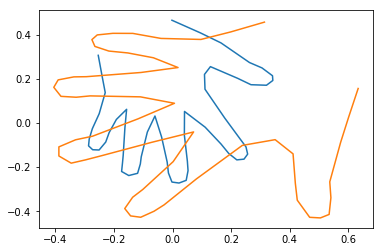

In [137]:
transformed = transform_hand(data[:,0], 2, 30/180)
plot_hand(data[:,1])
plot_hand(transformed)
# Adding legends with a custom plot function is nontrivial, so it is fine if the students find another way 
# to explain what is in the plot

**4d)** Aligning hands using gradient descent

In [138]:
# Computing the gradient of the squared distance function at the parameters (lambd, theta). 
# Note: You cannot use "lambda" as a parameter name in python, it is taken.
def distgrad(hand1, hand2, lambd, theta):
    num_coords = len(hand1)
    num_points = int(num_coords/2)
    partial_lambda = 0
    partial_theta = 0
    for i in np.arange(num_points):
        x1i = hand1[i]
        y1i = hand1[i+56]
        x2i = hand2[i]
        y2i = hand2[i+56]
        partial_lambda_part = 2*lambd*(x2i**2 + y2i**2) + 2*np.sin(theta)*(x1i*y2i - y1i*x2i) - 2*np.cos(theta)*(y2i*y1i + x2i*x1i)
        partial_theta_part = 2*lambd*(np.sin(theta)*(y2i*y1i + x2i*x1i) + np.cos(theta)*(y2i*x1i - y1i*x2i))
        partial_lambda = partial_lambda + partial_lambda_part
        partial_theta = partial_theta + partial_theta_part
        
    return np.array([partial_lambda, partial_theta])

In [139]:
# For debugging purposes: the distance function we are optimizing as well as a numerical estimate of the gradient
def distfun(hand1, hand2, lambd, theta):
    transformed_hand2 = transform_hand(hand2, lambd, theta)
    return np.linalg.norm(hand1-transformed_hand2)**2

def num_grad(hand1, hand2, lambd, theta):
    delta = 0.00001
    grad_lambda = (distfun(hand1, hand2, lambd + delta, theta) - distfun(hand1, hand2, lambd, theta))/delta
    grad_theta = (distfun(hand1, hand2, lambd, theta + delta) - distfun(hand1, hand2, lambd, theta))/delta
    return np.array([grad_lambda, grad_theta])

hand1 = data[:,0]
hand2 = data[:,1]

In [145]:
# Now to the meat: Using gradient descent, find the lambda and theta that optimally aligns hand2 to hand1
def grad_desc_alignment(hand1, hand2):    
    # Initialize theta
    cur_theta = 0 
    cur_lambda = 1
    # Set learning rate
    learningrate = 0.01
    # Set max_iter
    max_iter = 10000
    # Set convergence threshold for size of derivative
    conv_th = 0.0001
    
    conv = 0
    it = 0
    #Eval = np.zeros([1, max_iter])
        
    while conv == 0:
        it = it + 1
        
        cur_hand2 = transform_hand(hand2, cur_lambda, cur_theta)        
        grad = distgrad(hand1, hand2, cur_lambda, cur_theta)
        cur_lambda, cur_theta = [cur_lambda, cur_theta] - learningrate*grad
        if np.linalg.norm(grad) < conv_th:
            conv = 1
            print('converged after', it, 'iterations')
        elif it > max_iter:
            conv = 1
            print('reached macimal number of iterations:', it)
            
    return cur_hand2

converged after 235 iterations
reached macimal number of iterations: 10001
converged after 242 iterations
converged after 4874 iterations
converged after 313 iterations
converged after 202 iterations
converged after 1218 iterations
converged after 403 iterations
converged after 273 iterations
converged after 315 iterations
converged after 1028 iterations
converged after 612 iterations
converged after 603 iterations
converged after 775 iterations
converged after 334 iterations
converged after 543 iterations
converged after 1348 iterations
converged after 1415 iterations
converged after 274 iterations
converged after 267 iterations
converged after 321 iterations
converged after 219 iterations
converged after 416 iterations
converged after 214 iterations
converged after 552 iterations
reached macimal number of iterations: 10001
converged after 8199 iterations
converged after 212 iterations
reached macimal number of iterations: 10001
reached macimal number of iterations: 10001
converged af

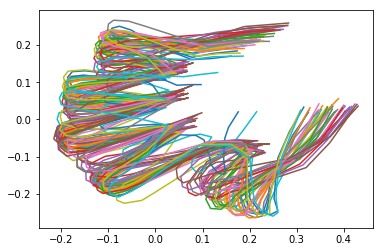

In [146]:
# Align all the hands
aligned_hands = np.zeros([112,40])
hand0 = data[:,0]
aligned_hands[:,0] = hand0
plot_hand(hand0)
for i in np.arange(1, 40):
    handi = data[:,i]  
    aligned_hands[:,i] = grad_desc_alignment(hand0, handi)
    plot_hand(aligned_hands[:,i])

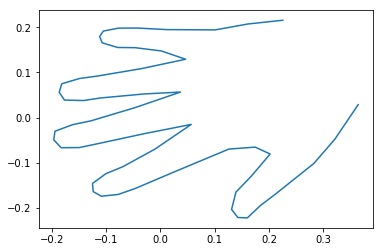

In [118]:
# Compute and plot the mean of the aligned hands
meanhand2 = np.mean(aligned_hands, 1)
plot_hand(meanhand2)